# data collection from Api

In [2]:
import requests
import pandas as pd

# Define a list of cities with their respective latitudes and longitudes
cities = {
    "Lahore": {"latitude": 31.5204, "longitude": 74.3587},
    "Quetta": {"latitude": 30.1798, "longitude": 66.9750},
    "Karachi": {"latitude": 24.8607, "longitude": 67.0011},
    "Islamabad": {"latitude": 33.6844, "longitude": 73.0479}
}

# Define the API endpoint
url = "https://archive-api.open-meteo.com/v1/archive"

# Function to fetch weather data for a city
def fetch_weather_data(city, lat, lon, start_date, end_date):
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration",
        "timezone": "auto"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if 'daily' in data:
            df = pd.DataFrame(data['daily'])
            df['city'] = city
            return df
        else:
            print(f"No daily data found for {city}.")
            return pd.DataFrame()
    else:
        print(f"Failed to fetch weather data for {city}. Status code: {response.status_code}")
        return pd.DataFrame()

# Define the date range for data collection
start_date = "2020-01-01"
end_date = "2024-05-26"

# Initialize an empty DataFrame to hold all cities' data
all_weather_data = pd.DataFrame()

# Loop through each city and fetch weather data
for city, coords in cities.items():
    lat = coords["latitude"]
    lon = coords["longitude"]
    city_weather_data = fetch_weather_data(city, lat, lon, start_date, end_date)
    all_weather_data = pd.concat([all_weather_data, city_weather_data], ignore_index=True)

# Save the collected data to a CSV file
all_weather_data.to_csv('weather_data_all_cities.csv', index=False)

print("Weather data for all cities saved to 'weather_data_all_cities.csv'.")



Weather data for all cities saved to 'weather_data_all_cities.csv'.


# data preprocessing

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


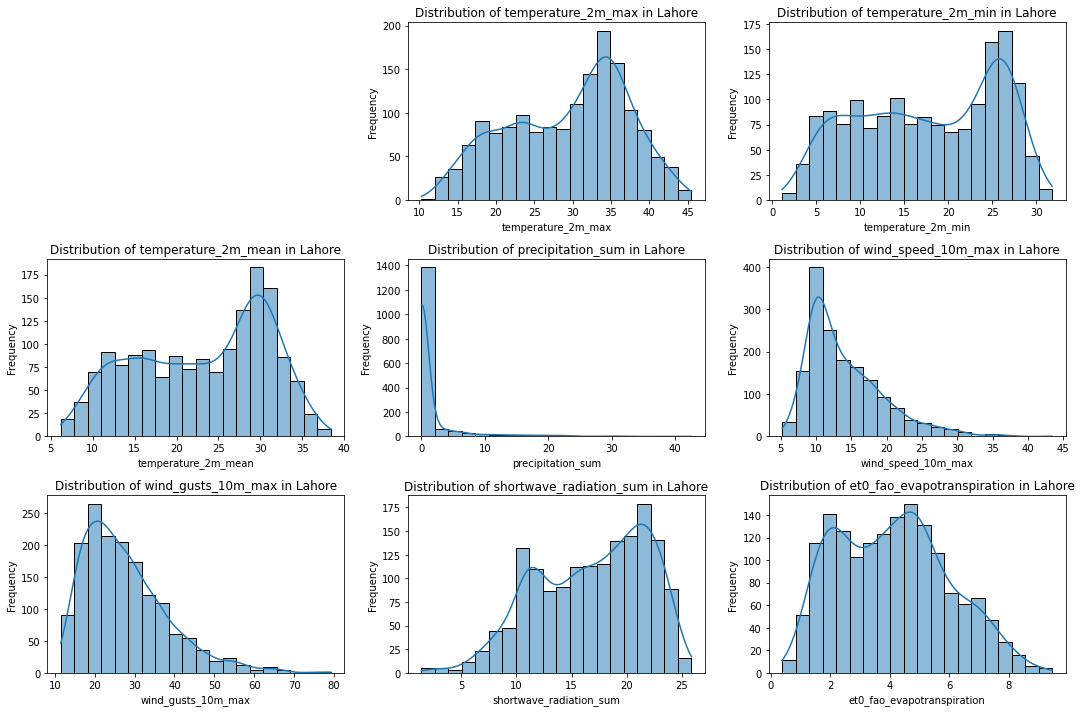

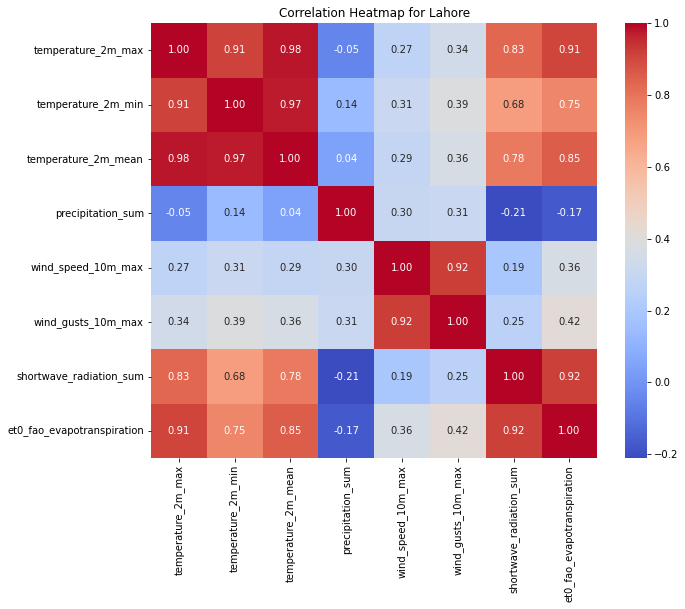

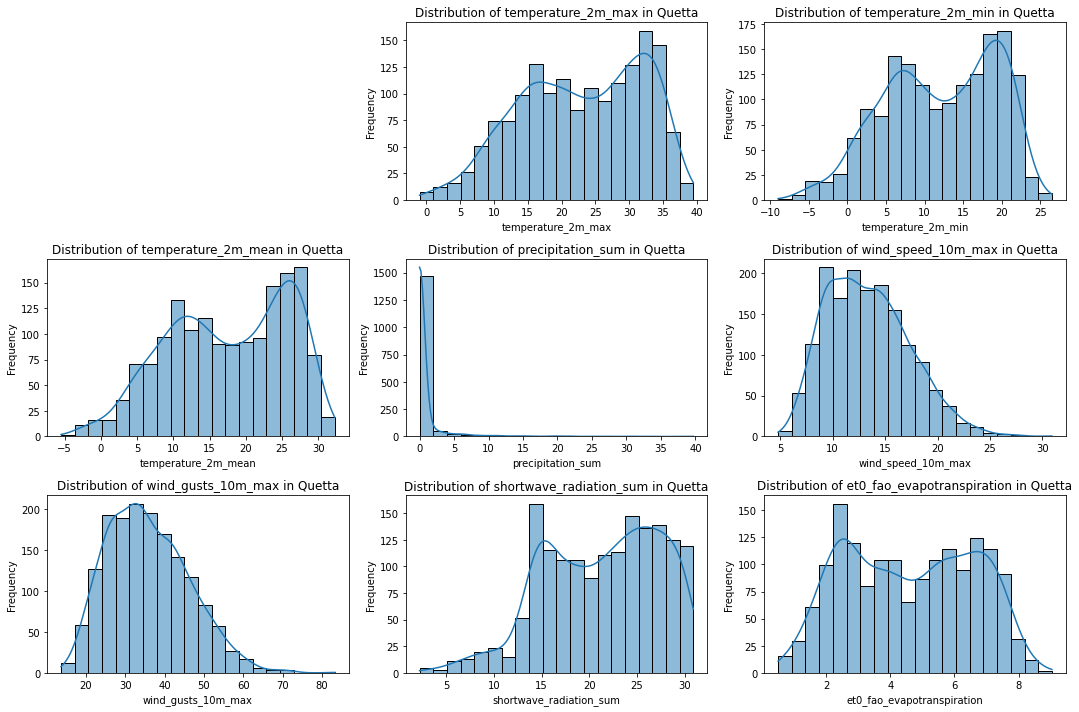

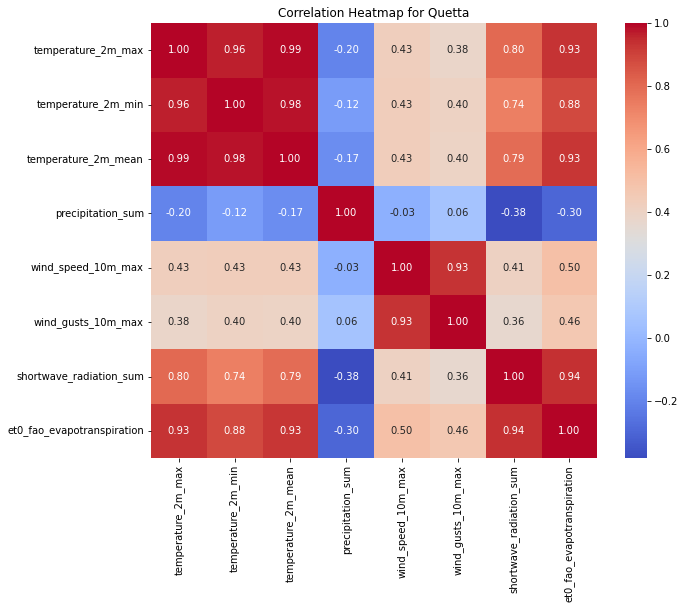

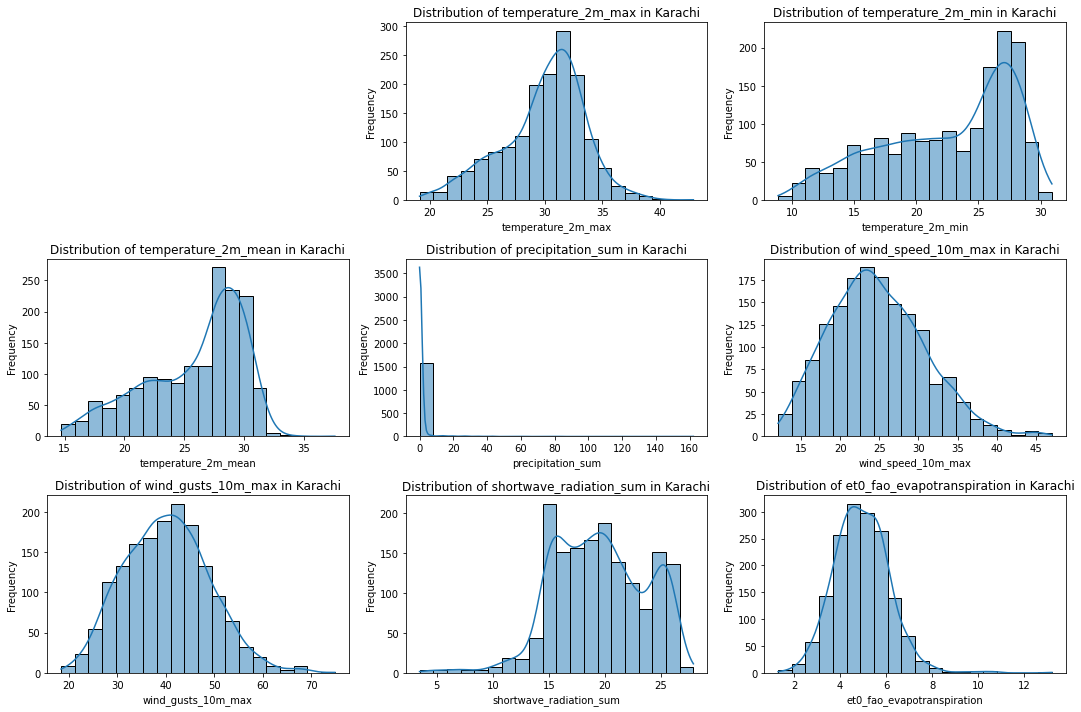

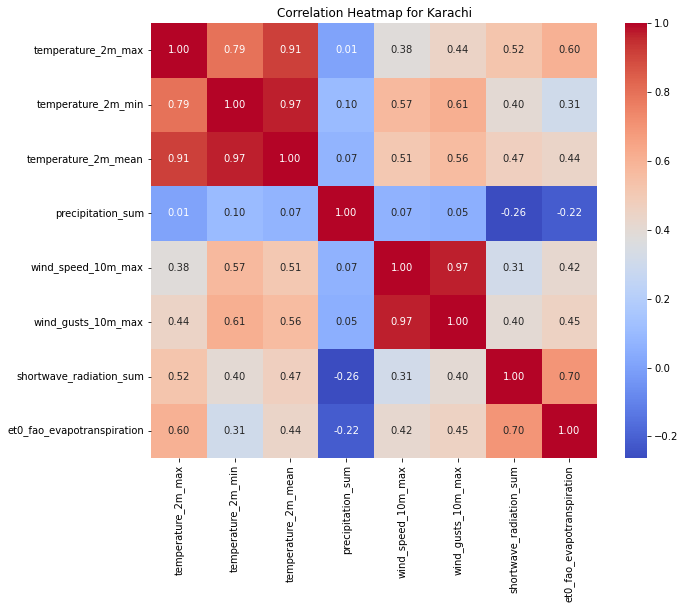

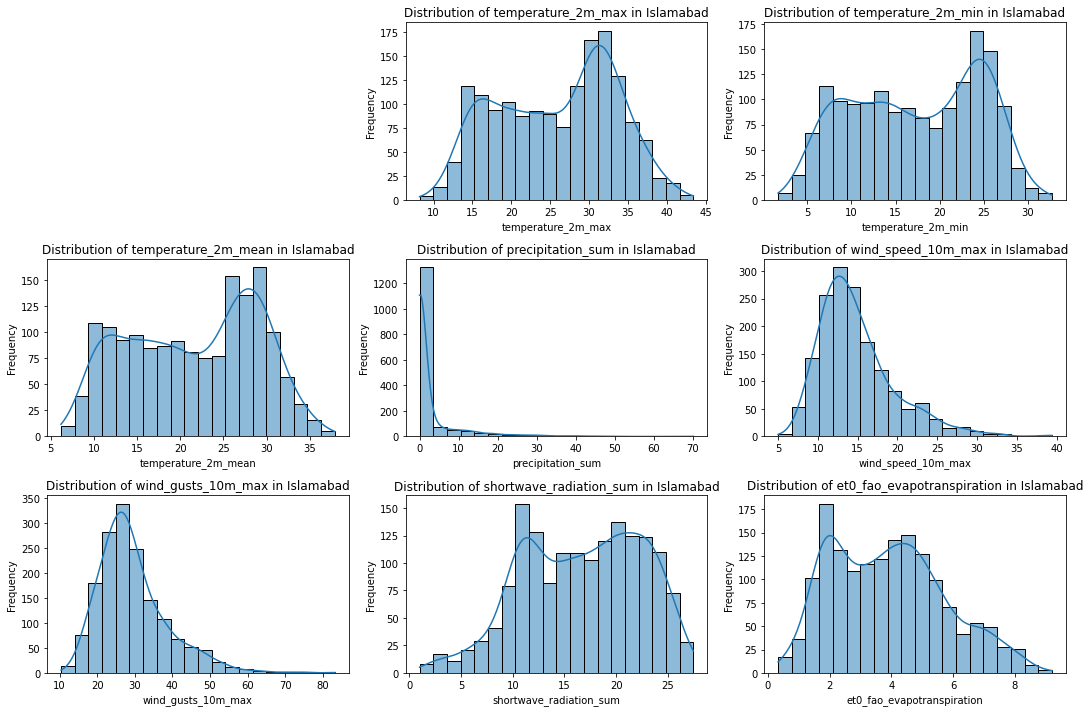

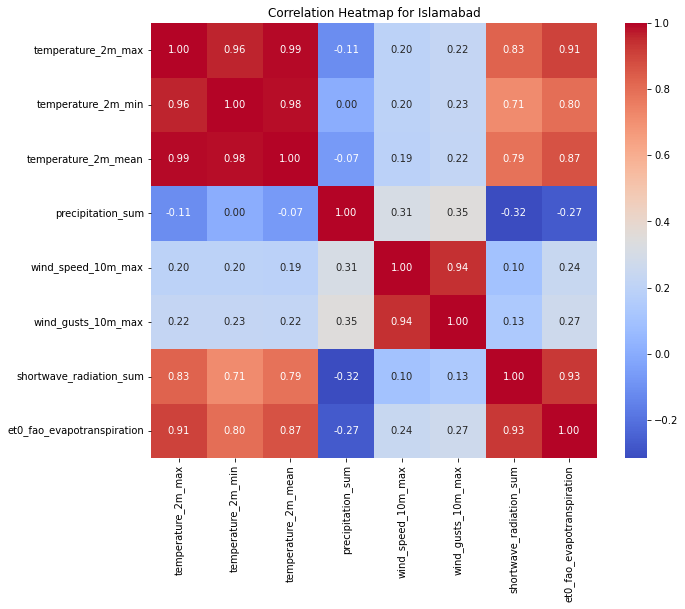

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the collected weather data
weather_data = pd.read_csv('weather_data_all_cities.csv')

# Data Preprocessing and Exploration for each city
for city in cities.keys():
    city_data = weather_data[weather_data['city'] == city].copy()  # Create a copy of the DataFrame
    
    # Handling missing values
    city_data.dropna(inplace=True)
    
    # Explore data distributions and handle outliers
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(city_data.columns):
        if city_data[column].dtype != 'object':  # Exclude non-numeric columns
            plt.subplot(3, 3, i + 1)
            sns.histplot(city_data[column], bins=20, kde=True)
            plt.title(f'Distribution of {column} in {city}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Convert categorical variables to numerical representations
    # One-hot encoding for city names
    city_data = pd.get_dummies(city_data, columns=['city'], drop_first=True)
    
    # Visualize correlations using a heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = city_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Heatmap for {city}')
    plt.show()



# feature engineering

   temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0                13.4                 2.0                  6.2   
1                18.0                 3.9                  9.5   
2                18.0                 4.2                 11.3   
3                16.4                 5.3                 10.6   
4                15.9                 5.1                 10.4   

   precipitation_sum  wind_speed_10m_max  wind_gusts_10m_max  \
0                0.0                10.1                15.8   
1                0.0                10.4                21.2   
2                0.0                 9.6                17.3   
3                0.2                10.2                21.2   
4                1.0                 8.6                15.1   

   shortwave_radiation_sum  et0_fao_evapotranspiration    city  day_of_week  \
0                     9.36                        1.23  Lahore            2   
1                    10.17                        1.61  Laho

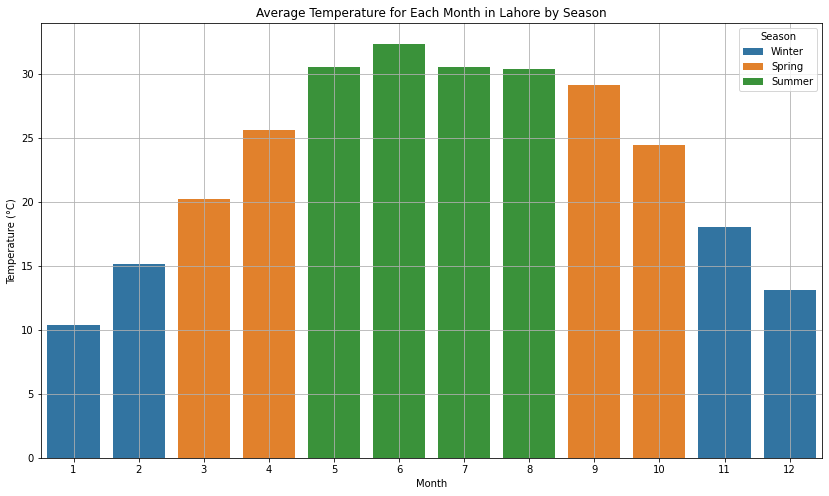

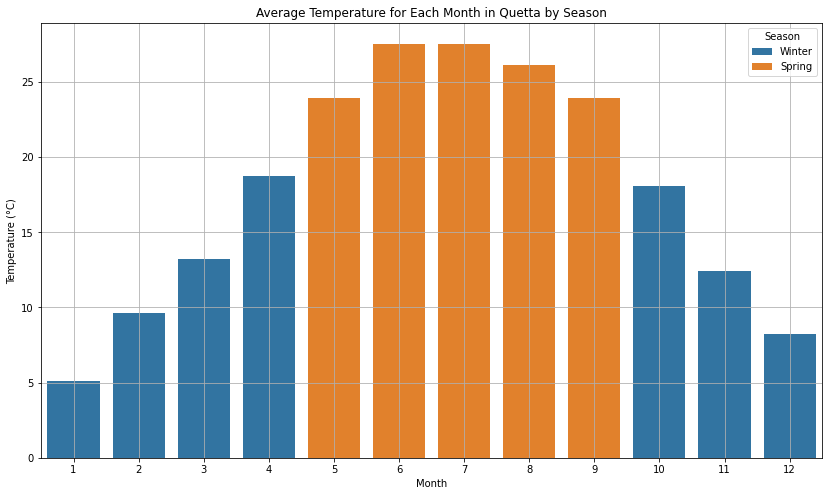

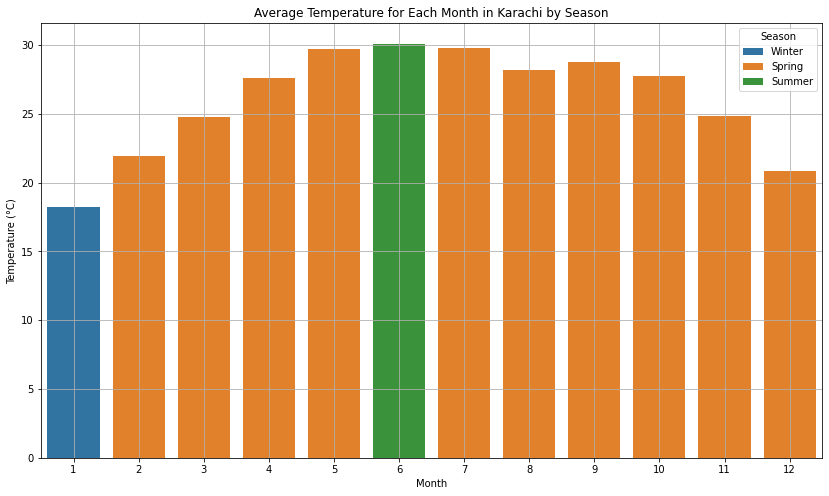

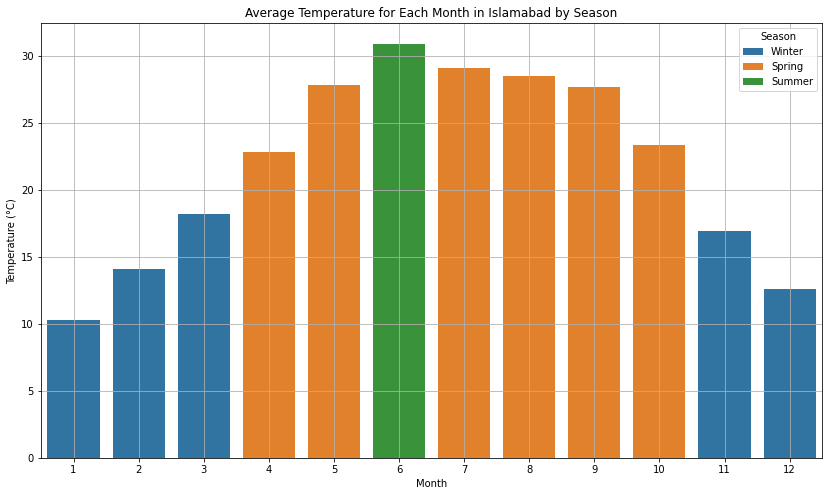

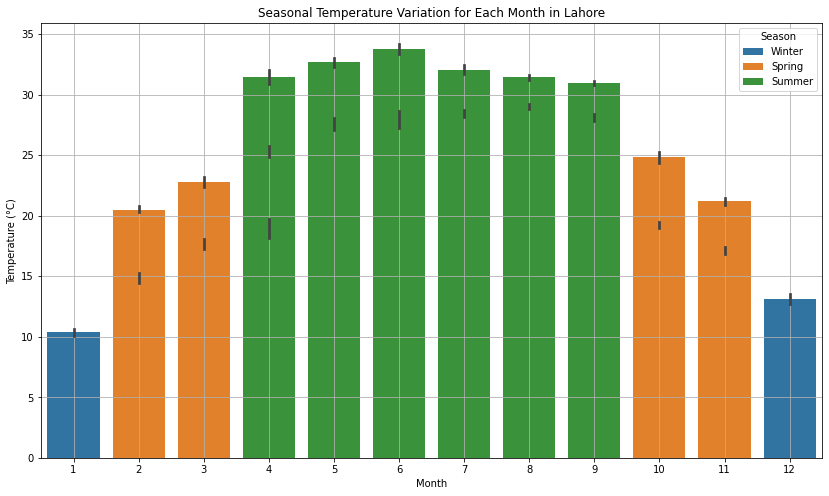

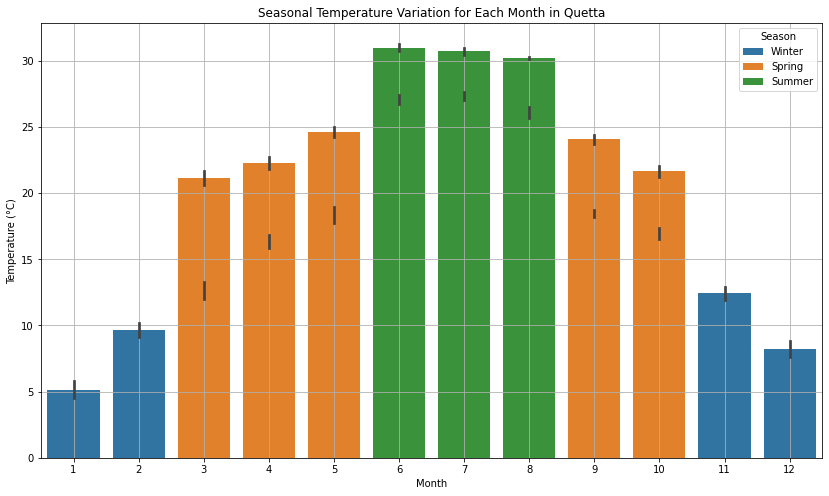

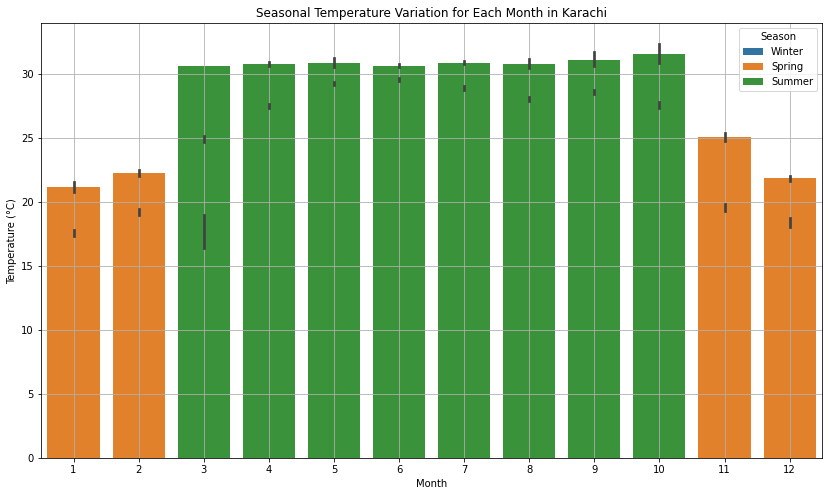

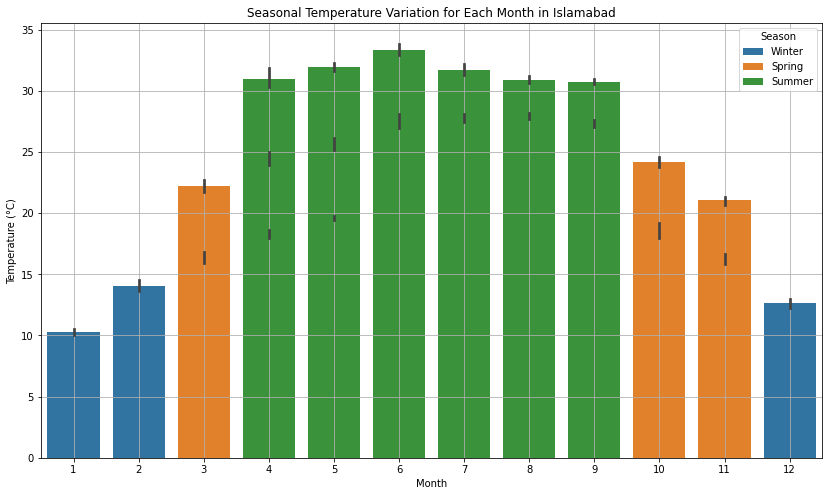

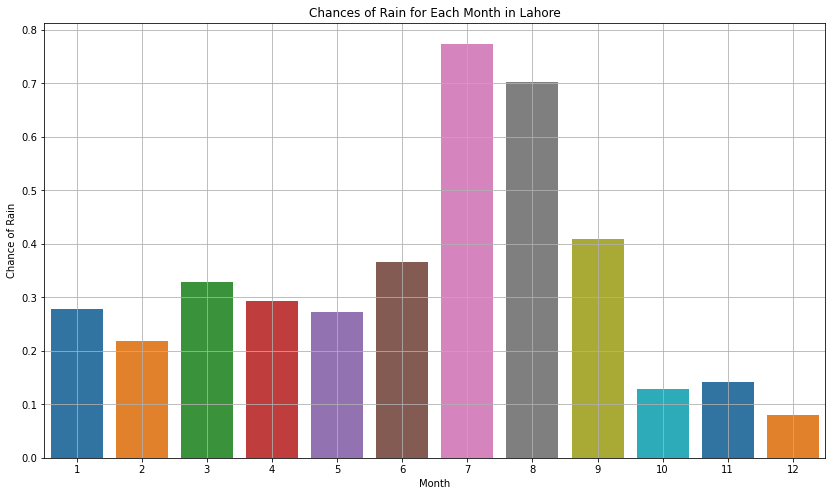

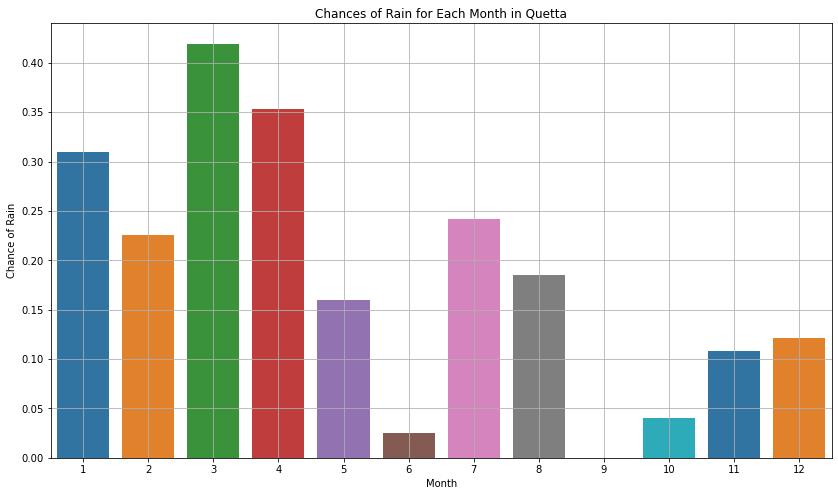

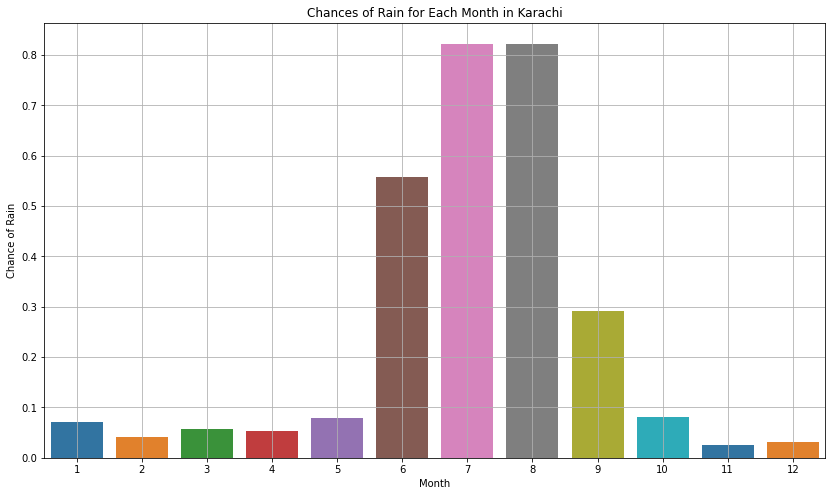

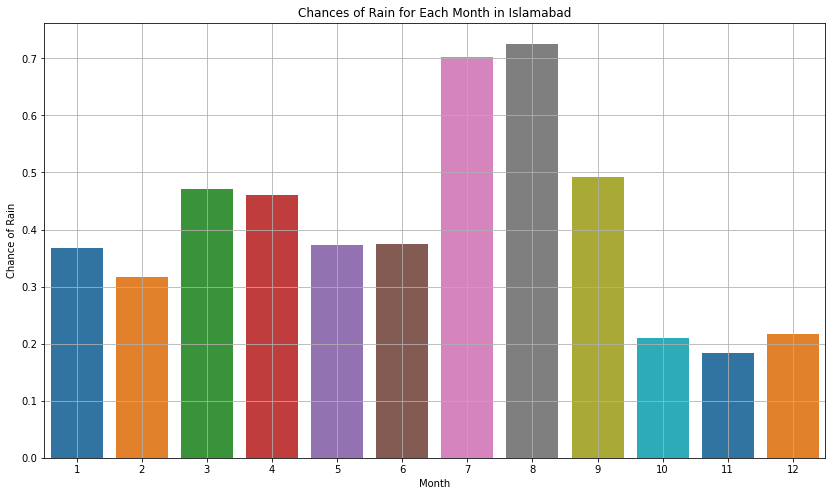

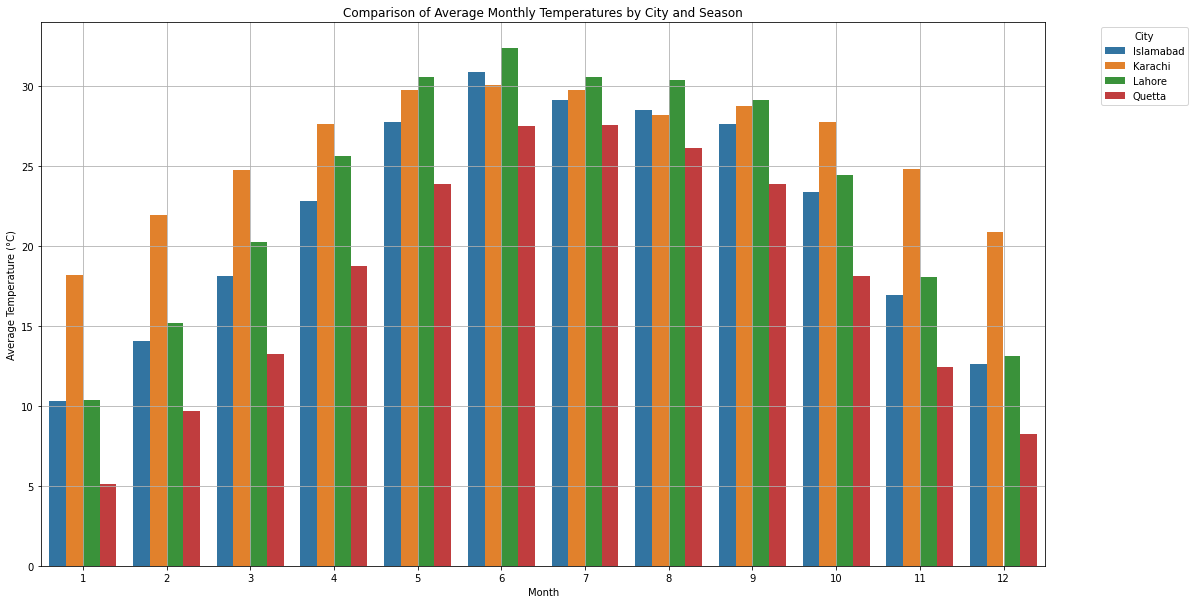

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed weather data
weather_data = pd.read_csv('weather_data_all_cities.csv')

# Feature Engineering
# Extracting temporal features
weather_data['date'] = pd.to_datetime(weather_data['time'])  # Convert 'time' column to datetime
weather_data['day_of_week'] = weather_data['date'].dt.dayofweek  # Extract day of the week (Monday=0, Sunday=6)
weather_data['month'] = weather_data['date'].dt.month  # Extract month

# Lagged variables (previous day's temperature)
weather_data['prev_day_temp_mean'] = weather_data.groupby('city')['temperature_2m_mean'].shift(1)

# Drop unnecessary columns after feature engineering
weather_data.drop(columns=['time', 'date'], inplace=True)  # Drop 'time' and 'date' columns as we have extracted temporal features

# Create a binary column for rain occurrence (1 if precipitation_sum > 0, else 0)
weather_data['rain'] = weather_data['precipitation_sum'] > 0

# Define seasons based on temperature
def determine_season(temp):
    if temp < 20:
        return 'Winter'
    elif 20 <= temp <= 30:
        return 'Spring'
    else:
        return 'Summer'

weather_data['season'] = weather_data['temperature_2m_mean'].apply(determine_season)

# Display the updated DataFrame with engineered features
print(weather_data.head())

# Group by city and month, then calculate the average temperature
monthly_avg_temp = weather_data.groupby(['city', 'month'])['temperature_2m_mean'].mean().reset_index()

# Add season information to the monthly average temperatures
monthly_avg_temp['season'] = monthly_avg_temp['temperature_2m_mean'].apply(determine_season)

# Visualization for each city - Highest Average Temperature
for city in weather_data['city'].unique():
    city_monthly_avg_temp = monthly_avg_temp[monthly_avg_temp['city'] == city]

    plt.figure(figsize=(14, 8))
    sns.barplot(data=city_monthly_avg_temp, x='month', y='temperature_2m_mean', hue='season', dodge=False, palette='tab10')
    plt.title(f'Average Temperature for Each Month in {city} by Season')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.legend(title='Season')
    plt.grid(True)
    plt.show()

# Visualization for each city - Seasons
for city in weather_data['city'].unique():
    city_data = weather_data[weather_data['city'] == city]
    
    plt.figure(figsize=(14, 8))
    sns.barplot(data=city_data, x='month', y='temperature_2m_mean', hue='season', dodge=False, palette='tab10')
    plt.title(f'Seasonal Temperature Variation for Each Month in {city}')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.legend(title='Season')
    plt.grid(True)
    plt.show()

# Group by city and month, then calculate the probability of rain
monthly_rain_chances = weather_data.groupby(['city', 'month'])['rain'].mean().reset_index()

# Visualization for each city - Chances of Rain
for city in weather_data['city'].unique():
    city_monthly_rain_chances = monthly_rain_chances[monthly_rain_chances['city'] == city]

    plt.figure(figsize=(14, 8))
    sns.barplot(data=city_monthly_rain_chances, x='month', y='rain', palette='tab10')
    plt.title(f'Chances of Rain for Each Month in {city}')
    plt.xlabel('Month')
    plt.ylabel('Chance of Rain')
    plt.grid(True)
    plt.show()

# Combined visualization comparing all cities month and season-wise
plt.figure(figsize=(18, 10))
sns.barplot(data=monthly_avg_temp, x='month', y='temperature_2m_mean', hue='city', dodge=True, palette='tab10')
plt.title('Comparison of Average Monthly Temperatures by City and Season')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


# check data columns

In [5]:
print(weather_data.columns)

Index(['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
       'precipitation_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'city',
       'day_of_week', 'month', 'prev_day_temp_mean', 'rain', 'season'],
      dtype='object')


# data spliting

In [6]:
from sklearn.model_selection import train_test_split

# Define the features (X) and target variable (y)
X = weather_data.drop(columns=['temperature_2m_mean', 'city'])  # Features excluding target variable and city
y = weather_data['temperature_2m_mean']  # Target variable (mean temperature)

# Define indices for training and testing sets
train_indices = weather_data.sample(frac=0.8, random_state=42).index
test_indices = weather_data.drop(train_indices).index

# Split the data into training and testing sets using specific indices
X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

# Display the shape of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (5146, 12)
Shape of X_test: (1286, 12)
Shape of y_train: (5146,)
Shape of y_test: (1286,)


In [7]:

weather_data.dropna(inplace=True)

# model training

Mean Squared Error (MSE) for Each City:
                MSE
Lahore     0.298915
Quetta     0.252637
Karachi    0.135979
Islamabad  0.207889


<Figure size 720x432 with 0 Axes>

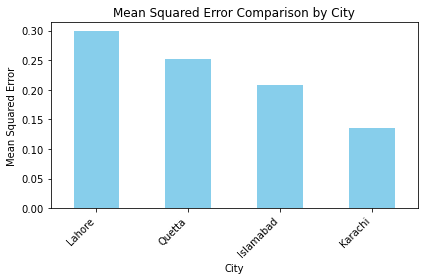

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the preprocessed weather data
weather_data = pd.read_csv('weather_data_all_cities.csv')

# Feature Engineering
# Extracting temporal features
weather_data['date'] = pd.to_datetime(weather_data['time'])  # Convert 'time' column to datetime
weather_data['day_of_week'] = weather_data['date'].dt.dayofweek  # Extract day of the week (Monday=0, Sunday=6)
weather_data['month'] = weather_data['date'].dt.month  # Extract month

# Lagged variables (previous day's temperature)
weather_data['prev_day_temp_mean'] = weather_data.groupby('city')['temperature_2m_mean'].shift(1)

# Drop unnecessary columns after feature engineering
weather_data.drop(columns=['time', 'date'], inplace=True)  # Drop 'time' and 'date' columns as we have extracted temporal features

# Remove rows with missing values
weather_data.dropna(inplace=True)

# Initialize an empty dictionary to store MSE values for each city
mse_per_city = {}

# Iterate over unique cities in the dataset
for city in weather_data['city'].unique():
    # Filter data for the current city
    city_data = weather_data[weather_data['city'] == city]
    
    # Define the features (X) and target variable (y) for the current city
    X_city = city_data.drop(columns=['temperature_2m_mean', 'city'])  # Features excluding target variable and city
    y_city = city_data['temperature_2m_mean']  # Target variable (mean temperature)
    
    # Define indices for training and testing sets for the current city
    city_indices = city_data.index
    train_indices = city_data.sample(frac=0.8, random_state=42).index
    test_indices = city_data.drop(train_indices).index
    
    # Split the data into training and testing sets for the current city using specific indices
    X_train_city = X_city.loc[train_indices]
    X_test_city = X_city.loc[test_indices]
    y_train_city = y_city.loc[train_indices]
    y_test_city = y_city.loc[test_indices]
    
    # Initialize the Random Forest Regression model for the current city
    rf_model_city = RandomForestRegressor(random_state=42)
    
    # Train the model on the training data for the current city
    rf_model_city.fit(X_train_city, y_train_city)
    
    # Evaluate the model on the testing set for the current city
    y_pred_city = rf_model_city.predict(X_test_city)
    mse_city = mean_squared_error(y_test_city, y_pred_city)
    
    # Store the MSE value for the current city
    mse_per_city[city] = mse_city

# Convert the MSE dictionary to a pandas DataFrame
mse_df = pd.DataFrame.from_dict(mse_per_city, orient='index', columns=['MSE'])

# Print the MSE for each city
print("Mean Squared Error (MSE) for Each City:")
print(mse_df)

# Plot the MSE comparison for each city
plt.figure(figsize=(10, 6))
mse_df.sort_values(by='MSE', ascending=False).plot(kind='bar', color='skyblue', legend=None)
plt.title('Mean Squared Error Comparison by City')
plt.xlabel('City')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# model evaluation

City: Islamabad
Mean Absolute Error (MAE): 0.3710591900311516
Mean Squared Error (MSE): 0.20788929595015512
Root Mean Squared Error (RMSE): 0.45594878654313264




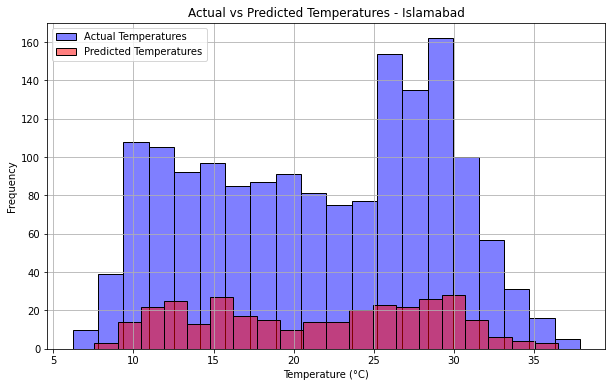

City: Karachi
Mean Absolute Error (MAE): 0.25041744548286615
Mean Squared Error (MSE): 0.13597915264797497
Root Mean Squared Error (RMSE): 0.36875351204832607




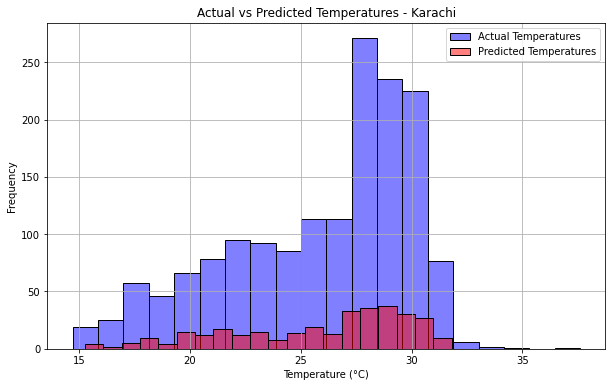

City: Lahore
Mean Absolute Error (MAE): 0.4124485981308417
Mean Squared Error (MSE): 0.29891538940810075
Root Mean Squared Error (RMSE): 0.5467315515022896




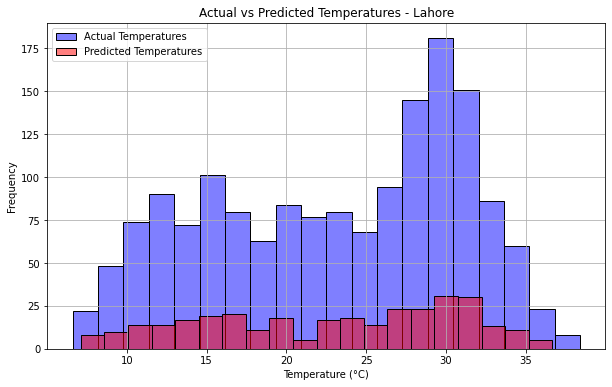

City: Quetta
Mean Absolute Error (MAE): 0.38361682242990697
Mean Squared Error (MSE): 0.2526373489096581
Root Mean Squared Error (RMSE): 0.5026304297489937




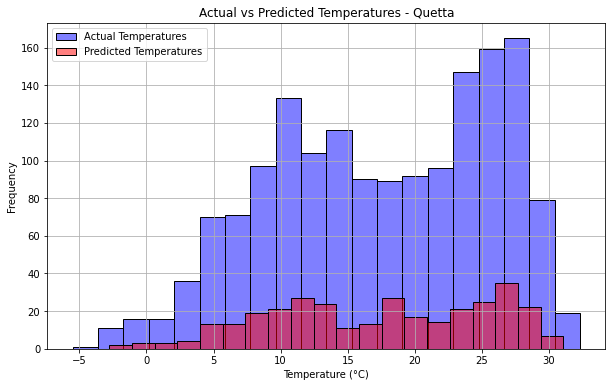

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed weather data
weather_data = pd.read_csv('weather_data_all_cities.csv')

# Feature Engineering
# Extracting temporal features
weather_data['date'] = pd.to_datetime(weather_data['time'])  # Convert 'time' column to datetime
weather_data['day_of_week'] = weather_data['date'].dt.dayofweek  # Extract day of the week (Monday=0, Sunday=6)
weather_data['month'] = weather_data['date'].dt.month  # Extract month

# Lagged variables (previous day's temperature)
weather_data['prev_day_temp_mean'] = weather_data.groupby('city')['temperature_2m_mean'].shift(1)

# Drop unnecessary columns after feature engineering
weather_data.drop(columns=['time', 'date'], inplace=True)  # Drop 'time' and 'date' columns as we have extracted temporal features

# Remove rows with missing values
weather_data.dropna(inplace=True)

# Define a function to train and evaluate the model for each city
def train_evaluate_model(city_data, train_indices, test_indices):
    X = city_data.drop(columns=['temperature_2m_mean', 'city'])  # Features excluding target variable and city
    y = city_data['temperature_2m_mean']  # Target variable (mean temperature)

    # Split the data into training and testing sets using specific indices
    X_train, X_test = X.loc[train_indices], X.loc[test_indices]
    y_train, y_test = y.loc[train_indices], y.loc[test_indices]

    # Initialize the Random Forest Regression model
    rf_model = RandomForestRegressor(random_state=42)

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    # Evaluate the model on the testing set
    y_pred = rf_model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse, y_pred, y_test

# Iterate over each city, train and evaluate the model, and print the evaluation metrics
for city_name, city_data in weather_data.groupby('city'):
    print(f"City: {city_name}")
    
    # Define indices for training and testing sets for the current city
    city_indices = city_data.index
    train_indices = city_data.sample(frac=0.8, random_state=42).index
    test_indices = city_data.drop(train_indices).index
    
    mae, mse, rmse, y_pred, y_test = train_evaluate_model(city_data, train_indices, test_indices)
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("\n")

    # Visualize the comparison
    plt.figure(figsize=(10, 6))
    sns.histplot(city_data['temperature_2m_mean'], bins=20, color='blue', alpha=0.5, label='Actual Temperatures')
    sns.histplot(y_pred, bins=20, color='red', alpha=0.5, label='Predicted Temperatures')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.title(f'Actual vs Predicted Temperatures - {city_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


# forecasting

Enter the number of forecasting days: 30


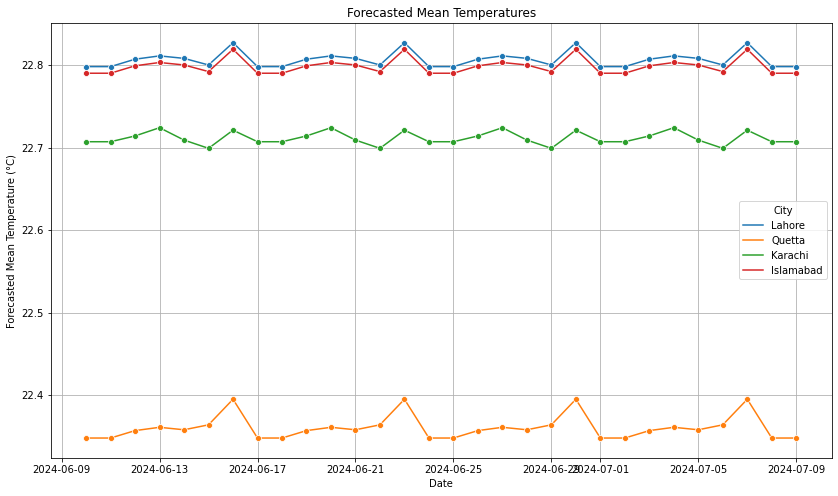


Forecasted Mean Temperatures for Lahore:
   forecast_date  forecasted_mean_temp
0     2024-06-10                22.798
1     2024-06-11                22.798
2     2024-06-12                22.807
3     2024-06-13                22.811
4     2024-06-14                22.808
5     2024-06-15                22.800
6     2024-06-16                22.827
7     2024-06-17                22.798
8     2024-06-18                22.798
9     2024-06-19                22.807
10    2024-06-20                22.811
11    2024-06-21                22.808
12    2024-06-22                22.800
13    2024-06-23                22.827
14    2024-06-24                22.798
15    2024-06-25                22.798
16    2024-06-26                22.807
17    2024-06-27                22.811
18    2024-06-28                22.808
19    2024-06-29                22.800
20    2024-06-30                22.827
21    2024-07-01                22.798
22    2024-07-02                22.798
23    2024-07-03      

In [12]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed weather data
weather_data = pd.read_csv('weather_data_all_cities.csv')

# Feature Engineering
# Extracting temporal features
weather_data['date'] = pd.to_datetime(weather_data['time'])  # Convert 'time' column to datetime
weather_data['day_of_week'] = weather_data['date'].dt.dayofweek  # Extract day of the week (Monday=0, Sunday=6)
weather_data['month'] = weather_data['date'].dt.month  # Extract month

# Lagged variables (previous day's temperature)
weather_data['prev_day_temp_mean'] = weather_data.groupby('city')['temperature_2m_mean'].shift(1)

# Drop unnecessary columns after feature engineering
weather_data.drop(columns=['time', 'date'], inplace=True)  # Drop 'time' and 'date' columns as we have extracted temporal features

# Remove rows with missing values
weather_data.dropna(inplace=True)

# Define a function to train the model
def train_model(city_data, train_indices):
    X = city_data.drop(columns=['temperature_2m_mean', 'city'])  # Features excluding target variable and city
    y = city_data['temperature_2m_mean']  # Target variable (mean temperature)

    # Split the data into training and testing sets using specific indices
    X_train, X_test = X.loc[train_indices], X.drop(train_indices)
    y_train, y_test = y.loc[train_indices], y.drop(train_indices)

    # Initialize the Random Forest Regression model
    rf_model = RandomForestRegressor(random_state=42)

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    return rf_model

# Train the model on the entire dataset (for demonstration purposes)
train_indices, _ = train_test_split(weather_data.index, test_size=0.2, random_state=42)
rf_model = train_model(weather_data, train_indices)

# Function to fetch the latest weather data for a city
def fetch_current_weather_data(lat, lon):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "current_weather": "true",
        "timezone": "auto"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if 'current_weather' in data:
            return data['current_weather']
        else:
            print("No current weather data found.")
            return None
    else:
        print("Failed to fetch current weather data. Status code:", response.status_code)
        return None

# Cities with their respective latitudes and longitudes
cities = {
    "Lahore": {"latitude": 31.5204, "longitude": 74.3587},
    "Quetta": {"latitude": 30.1798, "longitude": 66.9750},
    "Karachi": {"latitude": 24.8607, "longitude": 67.0011},
    "Islamabad": {"latitude": 33.6844, "longitude": 73.0479}
}

# Forecasting for the next 7 days using the latest data from the API
forecast_horizon = int(input("Enter the number of forecasting days: "))
forecast_results = []

# Get the current date
current_date = datetime.now().date()

for city, coords in cities.items():
    lat = coords["latitude"]
    lon = coords["longitude"]
    
    # Fetch the latest weather data
    current_weather = fetch_current_weather_data(lat, lon)
    
    if current_weather:
        # Prepare the feature vector using the latest weather data
        recent_data = {
            'temperature_2m_max': current_weather['temperature'],
            'temperature_2m_min': current_weather['temperature'],
            'precipitation_sum': 0,  # Assuming no precipitation in current data
            'wind_speed_10m_max': current_weather['windspeed'],
            'wind_gusts_10m_max': current_weather['windspeed'],
            'shortwave_radiation_sum': 0,  # Assuming no radiation data in current data
            'et0_fao_evapotranspiration': 0,  # Assuming no evapotranspiration data in current data
            'prev_day_temp_mean': current_weather['temperature'],
            'day_of_week': current_date.weekday(),
            'month': current_date.month
        }
        
        for i in range(forecast_horizon):
            # Prepare the feature vector for prediction
            feature_vector = pd.DataFrame([recent_data])
            
            # Predict the mean temperature
            forecast_temp = rf_model.predict(feature_vector)[0]
            
            # Append the result
            forecast_results.append({
                'city': city,
                'forecast_date': current_date + timedelta(days=i),
                'forecasted_mean_temp': forecast_temp
            })
            
            # Update the recent_data for the next prediction
            recent_data['prev_day_temp_mean'] = forecast_temp
            recent_data['day_of_week'] = (recent_data['day_of_week'] + 1) % 7
            if recent_data['day_of_week'] == 0:
                recent_data['month'] = (recent_data['month'] % 12) + 1
    else:
        print(f"Failed to fetch current weather data for {city}. Skipping forecast.")

# Convert forecast results to a DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Visualize the forecast results
plt.figure(figsize=(14, 8))
sns.lineplot(data=forecast_df, x='forecast_date', y='forecasted_mean_temp', hue='city', marker='o')

plt.title('Forecasted Mean Temperatures')
plt.xlabel('Date')
plt.ylabel('Forecasted Mean Temperature (°C)')
plt.legend(title='City')
plt.grid(True)
plt.show()

# Compare the forecasted temperatures
for city in forecast_df['city'].unique():
    city_forecast = forecast_df[forecast_df['city'] == city]
    print(f"\nForecasted Mean Temperatures for {city}:")
    print(city_forecast[['forecast_date', 'forecasted_mean_temp']])
